# Sign spotting analysis
In this notebook, we analyze the differences between the three models that we created: the one that was trained using engineered features meant to represent phonology (the *linguistic model*), the one that was trained using Mediapipe landmarks (the *landmark model*), and the model which used both sets of the previously mentioned features (the *combined model*). We study the models in a few different ways:

1. We compare each model to determine whether there is a significant difference in performance between them. Specifically, we compare their performance in terms of our distractor-based evaluation method. Each model was run five times to allow us to determine whether the differences in performance were significant.
1. We observe which true positive (TP) spottings of each target sign are made by the models. The TP spottings that are made by one model and not the other(s) are explicitly printed so we can manually analyze these instances.
1. We investigate which false positive (FP) spottings occur for a set of confusable signs. These confusable signs are determined for each target, and we find those signs to be confusable signs for a given target if they only differ in one linguistic property (the *distance property*) from that target sign, e.g. the handedness. We determine which distance properties are especially confusable for each model by seeing how often the confusable signs are spotted and keeping track of their distance properties.

In [1]:
# imports
import os
import copy
from scipy.stats import ttest_ind
import numpy as np
from scipy.spatial.distance import cdist
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import textwrap

from tensorflow import keras
from keras.optimizers import Adam

import importlib

# Keep python tools up to date
from tools import tools, create_model, constants, sign_spot_tools, analysis
importlib.reload(tools)
importlib.reload(create_model)
importlib.reload(constants)
importlib.reload(sign_spot_tools)
importlib.reload(analysis)

# Import all functions from the tools
from tools.tools import load_dict
from tools.create_model import SupCon_loss, create_encoder
from tools.constants import PATHS, USE_MOUTHINGS, MODEL_PARAMS, ANN_LENGTH # Path constants
from tools.sign_spot_tools import make_video_embds 
from tools.analysis import*

# Set a numpy seed for consistent results
np.random.seed(123)

In [2]:
paths = ['model_checkpoint', 'anns_test'] # 'embeddings', 
model_modes = ['_only_lmrks', '_only_ling', '_combined']
num_modes = len(model_modes)
all_paths_known = True
temperature = MODEL_PARAMS['temperature']

metric_names = ['TP', 'FN', 'FP', 'TN', 'Accuracy', 'Precision', 'Recall', 'F1-score']

In [3]:
# Load the data to get the number of classes
y_train_no_mirr = np.load(PATHS['dataset_root'] + 'CNGT_y_train_combined__top.npy')
# We use only the non-mirrored, not augmented train data to make reference embeddings
y_train_labels = np.array(list(set(y_train_no_mirr)))
num_classes = y_train_labels.shape[0]
print('Number of classes:', num_classes)

Number of classes: 2712


In [4]:
# Load the model checkpoints, make sure you trained both model types for this!
# Otherwise a warning will be printed and you cannot run the rest of the code.
for path in paths:
    for model_mode in model_modes:
        full_path = PATHS[path].format(model_mode)
        if not os.path.exists(full_path):
            all_paths_known = False
            print('Unknown path:', full_path)
            break

models = {}
embeddings = {}
if all_paths_known:
    print('Loading required data...')
    for model_mode in model_modes:
        model = keras.models.load_model(PATHS['model_checkpoint'].format(model_mode), 
                                         custom_objects={'SupCon_loss':SupCon_loss}, compile=False) 
        model.compile(optimizer = 'Adam', loss=SupCon_loss(temperature, num_classes))
        models[model_mode] = model

    # Load the test set annotations
    anns = load_dict(PATHS['anns_test'])
    print('Successfully loaded checkpoints and reference embeddings.')
else:
    print('***WARNING: you should run sign_spotting_training for the landmark, linguistic and combined features.***')
    print('***The code below will NOT run without both checkpoints and their corresponding reference embds.***')

Loading required data...
Successfully loaded checkpoints and reference embeddings.


# Comparing feature sets

In [5]:
# This dataframe is crafted from doing 5 runs per feature set - uses the linguistic features WITH feature selection
df = pd.read_csv('./results/results_tol_10.csv')
display(df.head())

significance_tests = []
for col in df.columns:
    if 'test' not in col:
        continue
    for i in range(num_modes):
        for j in range(i+1, num_modes):
            mode_1, mode_2 = model_modes[i], model_modes[j]
            which_modes = mode_1 + ' vs ' + mode_2
            metric_1 = df[df['Mode'] == mode_1][col].tolist()
            metric_2 = df[df['Mode'] == mode_2][col].tolist()
            t_test = ttest_ind(metric_1, metric_2, equal_var = True)
            mean_1, mean_2 = np.mean(metric_1), np.mean(metric_2)
            mode_1_better = mean_1 > mean_2
            p_val = t_test.pvalue
            significance_tests.append([col, mode_1, mode_2, mean_1, mean_2, 
                                       mode_1_better, p_val, p_val < 0.05])

significance_tests_df = pd.DataFrame(significance_tests, columns = ['Metric', 'Mode 1', 'Mode 2', 'Mode 1 average', 
                                                                    'Mode 2 average', 'Mode 1 higher?', 'p-value',
                                                                   'p-val significant?'])
significance_tests_df = significance_tests_df.head(n = significance_tests_df.shape[0]).round(3)
display(significance_tests_df)
significance_tests_df.to_csv('./results/feature_set_comparison.csv', index = False)

,Mode,TP (val),FN (val),FP (val),TN (val),acc (val),prec (val),rec (val),f1 (val),TP (test),...,rec (test),f1 (test),TP (val random),FN (val random),FP (val random),TN (val random),acc (val random),prec (val random),rec (val random),f1 (val random)
0,_combined,5997,4603,1940,8651,0.691,0.756,0.566,0.647,5379,...,0.554,0.640,5997,4603,1015,9576,0.735,0.855,0.566,0.681
1,_combined,5880,4720,1824,8767,0.691,0.763,0.555,0.643,5205,...,0.536,0.627,5880,4720,909,9682,0.734,0.866,0.555,0.676
2,_combined,5874,4726,1911,8680,0.687,0.755,0.554,0.639,5283,...,0.544,0.634,5874,4726,945,9646,0.732,0.861,0.554,0.674
3,_combined,5940,4660,1886,8705,0.691,0.759,0.560,0.644,5241,...,0.540,0.629,5940,4660,934,9657,0.736,0.864,0.560,0.680
4,_combined,5971,4629,1951,8640,0.689,0.754,0.563,0.645,5214,...,0.537,0.628,5971,4629,987,9604,0.735,0.858,0.563,0.680


,Metric,Mode 1,Mode 2,Mode 1 average,Mode 2 average,Mode 1 higher?,p-value,p-val significant?
0,TP (test),_only_lmrks,_only_ling,5251.000,5256.800,False,0.841,False
1,TP (test),_only_lmrks,_combined,5251.000,5264.400,False,0.705,False
2,TP (test),_only_ling,_combined,5256.800,5264.400,False,0.855,False
3,FN (test),_only_lmrks,_only_ling,4457.000,4451.200,True,0.841,False
4,FN (test),_only_lmrks,_combined,4457.000,4443.600,True,0.705,False
5,FN (test),_only_ling,_combined,4451.200,4443.600,True,0.855,False
6,FP (test),_only_lmrks,_only_ling,1742.000,1758.600,False,0.462,False
7,FP (test),_only_lmrks,_combined,1742.000,1692.400,True,0.002,True
8,FP (test),_only_ling,_combined,1758.600,1692.400,True,0.017,True
9,TN (test),_only_lmrks,_only_ling,7945.000,7928.400,True,0.462,False


In [6]:
num_test_targets = int(df['TP (test)'].iloc[0] + df['FN (test)'].iloc[0])
display(num_test_targets)

9708

# Distractor-based evaluation

In [7]:
%%time
# Create reference embeddings for all the signs
for model_mode in model_modes:
    print('Loading data + making reference embeddings for {} model'.format(model_mode))
    # Load the right features given the model mode
    X_train_no_mirr, y_train_no_mirr = get_data(model_mode, USE_MOUTHINGS)[2:4]
    # We use only the non-mirrored, not augmented train data to make reference embeddings
    y_train_labels = np.array(list(set(y_train_no_mirr)))
    reference_sign_embds = ref_embds(models[model_mode], X_train_no_mirr, y_train_no_mirr, y_train_labels, top_ratio = 0.1)
    embeddings[model_mode] = reference_sign_embds

Loading data + making reference embeddings for _only_lmrks model


,train,train_no_mirror,val,test
features shape,"(180432, 10, 84)","(90216, 10, 84)","(10295, 10, 84)","(9585, 10, 84)"
labels shape,"(180432,)","(90216,)","(10295,)","(9585,)"


100%|██████████████████████████████████████████████████████████████████████████████| 2712/2712 [00:51<00:00, 53.03it/s]


Loading data + making reference embeddings for _only_ling model


,train,train_no_mirror,val,test
features shape,"(180432, 10, 101)","(90216, 10, 101)","(10295, 10, 101)","(9585, 10, 101)"
labels shape,"(180432,)","(90216,)","(10295,)","(9585,)"


100%|██████████████████████████████████████████████████████████████████████████████| 2712/2712 [00:49<00:00, 55.06it/s]


Loading data + making reference embeddings for _combined model


,train,train_no_mirror,val,test
features shape,"(180432, 10, 171)","(90216, 10, 171)","(10295, 10, 171)","(9585, 10, 171)"
labels shape,"(180432,)","(90216,)","(10295,)","(9585,)"


100%|██████████████████████████████████████████████████████████████████████████████| 2712/2712 [00:47<00:00, 57.35it/s]

CPU times: total: 3min 56s
Wall time: 4min 19s


In [8]:
%%time
# Create embeddings of the test set videos with a sliding window for each model (each creates different embeddings) 
vid_embds = {}
for model_mode in model_modes:    
    print('Embedding test set videos with {} model...'.format(model_mode.replace('_', ' ')))
    _, vid_embd = make_video_embds(models[model_mode], model_mode, mouthings = USE_MOUTHINGS)
    vid_embds[model_mode] = vid_embd

Embedding test set videos with  only lmrks model...
Loading annotations and getting test video ids...
Loading test video features...


100%|███████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 407.27it/s]


Creating embeddings...
Batch shape: (415003, 10, 84)


100%|██████████████████████████████████████████████████████████████████████████████| 3243/3243 [01:09<00:00, 46.52it/s]


Number of embeds: (415003, 256)


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:08<00:00, 14.89it/s]


Done.                                                                                                    
Embedding test set videos with  only ling model...
Loading annotations and getting test video ids...
Loading test video features...


100%|███████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 247.77it/s]


Creating embeddings...
Batch shape: (415003, 10, 101)


100%|██████████████████████████████████████████████████████████████████████████████| 3243/3243 [01:10<00:00, 46.22it/s]


Number of embeds: (415003, 256)


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:05<00:00, 22.34it/s]


Done.                                                                                                    
Embedding test set videos with  combined model...
Loading annotations and getting test video ids...
Loading test video features...


100%|███████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 128.73it/s]


Creating embeddings...
Batch shape: (415003, 10, 171)


100%|██████████████████████████████████████████████████████████████████████████████| 3243/3243 [01:13<00:00, 44.26it/s]


Number of embeds: (415003, 256)


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:04<00:00, 26.81it/s]


Done.                                                                                                    
CPU times: total: 4min 14s
Wall time: 5min 22s


In [9]:
%%time
unknowns_as_distant = False
df_path = 'linguistic_distance_df_v2' if unknowns_as_distant else 'linguistic_distance_df'
dist_df = pd.read_csv(PATHS['linguistic_distance_df'], index_col = 0)
display(dist_df.head())

# Load the (string) labels of the (top) signs 
labels = load_dict(PATHS['label_encoder'].format('_top'))

fixed_tolerance = ANN_LENGTH
tolerances = [fixed_tolerance]

,AUKE-KUITERT-B,ABBE-DE-L'EPEE,VERANTWOORDELIJK,JAM-A,LAATSTE-A,LAATSTE-B,VERZEKERING,RIJLES,STATION-B,TROTS-A,...,AANVALLEN-ELKAAR-A,DIALECT-C,POLITIEBUREAU-B,SCHOENMAKER-C,ONBEWUST-A,ONBEWUST-B,X-B,JOEGOSLAVIE-B,HEEL-HOOG,PLUKKEN
AUKE-KUITERT-B,0.0,10.0,9.0,12.0,11.0,11.0,11.0,11.0,10.0,8.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,7.0
ABBE-DE-L'EPEE,10.0,0.0,7.0,10.0,7.0,9.0,8.0,6.0,7.0,8.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,3.0,10.0
VERANTWOORDELIJK,9.0,7.0,0.0,9.0,8.0,8.0,7.0,6.0,7.0,4.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,8.0
JAM-A,12.0,10.0,9.0,0.0,10.0,8.0,7.0,10.0,9.0,10.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,11.0
LAATSTE-A,11.0,7.0,8.0,10.0,0.0,6.0,6.0,5.0,6.0,7.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,11.0


CPU times: total: 4.14 s
Wall time: 4.54 s


In [10]:
# Given a set of distractors, randomly remove some and resample new distractors in their stead
def get_distractors_with_dropout(anns, labels, dist_df, tolerances, distractor_times, distractor_glosses,
                                 balanced = False, random = False, dropout_ratio = 0.10):
    # Flatten the distractor dicts to allow for sampling 
    flat_distractors = []

    for vid in distractor_times:
        for sign in distractor_times[vid]:
            for i, distractor_time in enumerate(distractor_times[vid][sign]):
                distractor_gloss = distractor_glosses[vid][sign][i]
                flat_distractors.append([vid, sign, distractor_time, distractor_gloss])
    num_distractors = len(flat_distractors)
    to_drop_idx = np.random.choice(np.arange(num_distractors), round(dropout_ratio*num_distractors), replace = False)
    to_drop_distractors = np.array(flat_distractors)[to_drop_idx].tolist()
    
    # Get the distractor's in terms of their timestamps, glosses/signs and their distance to the target sign
    distractor_times_new, distractor_glosses_new, linguistic_distances_new = get_distractors(anns, labels, dist_df, 
                                                                            tolerance = max(tolerances), 
                                                                            balanced = balanced, random = random, 
                                                                            forbidden_distractors = to_drop_distractors)
    return distractor_times_new, distractor_glosses_new, linguistic_distances_new

def dropout_experiments(vid_embd, embedding, random = False, dropout_ratio = 0.10, num_experiments = 10):
    experiment_results = []
    # Get the distractors without any dropout
    distractor_times, distractor_glosses, linguistic_distances = get_distractors(anns, labels, dist_df, 
                                                                                tolerance = max(tolerances), 
                                                                                balanced = False, random = random)
    
    _, results = distractor_based_eval(anns, vid_embd, embedding, labels, distractor_times, distractor_glosses, 
                                       spotting_thresh = 0.2, tolerance = fixed_tolerance)
    experiment_results.append(results + [np.mean(linguistic_distances), len(linguistic_distances)])
    for i in tqdm(range(num_experiments)):
        # Get the distractors if we randomly 'drop' some of them, such that they can't be used
        new_distractors = get_distractors_with_dropout(anns, labels, dist_df, tolerances, distractor_times, 
                                                       distractor_glosses, random = random, dropout_ratio = dropout_ratio)
        distractor_times_new, distractor_glosses_new, linguistic_distances_new = new_distractors

        _, results = distractor_based_eval(anns, vid_embd, embedding, labels, distractor_times_new, distractor_glosses_new, 
                                           spotting_thresh = 0.2, tolerance = fixed_tolerance)
        experiment_results.append(results + [np.mean(linguistic_distances_new), len(linguistic_distances_new)])
    
    idx = ['No dropout'] + ['Dropout ' + str(i+1) for i in range(num_experiments)]
    results_df = pd.DataFrame(experiment_results, columns=metric_names+['Mean ling. dist.', 'num. distractors'], 
                              index=idx).round(3)
    display(results_df)
    df_name = 'dropout_experiment_{}_{}.csv'.format(dropout_ratio, '_random' if random else '')
    results_df.to_csv('./results/'+df_name)

Here we run the dropout experiments at different levels of dropout.

In [11]:
%%time
mode_model = '_only_lmrks'
dropout_experiments(vid_embds[model_mode], embeddings[model_mode], dropout_ratio = 0.1)
dropout_experiments(vid_embds[model_mode], embeddings[model_mode], random = True, dropout_ratio = 0.1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:48<00:00, 10.84s/it]


,TP,FN,FP,TN,Accuracy,Precision,Recall,F1-score,Mean ling. dist.,num. distractors
No dropout,5369,4339,1777,7910,0.685,0.751,0.553,0.637,3.007,9687
Dropout 1,5369,4339,1770,7903,0.685,0.752,0.553,0.637,3.066,9673
Dropout 2,5369,4339,1748,7932,0.686,0.754,0.553,0.638,3.064,9680
Dropout 3,5369,4339,1753,7923,0.686,0.754,0.553,0.638,3.064,9676
Dropout 4,5367,4339,1737,7935,0.686,0.755,0.553,0.638,3.068,9672
Dropout 5,5369,4339,1761,7922,0.685,0.753,0.553,0.638,3.071,9683
Dropout 6,5369,4339,1725,7953,0.687,0.757,0.553,0.639,3.062,9678
Dropout 7,5369,4339,1735,7940,0.687,0.756,0.553,0.639,3.069,9675
Dropout 8,5369,4339,1734,7938,0.687,0.756,0.553,0.639,3.060,9672
Dropout 9,5369,4339,1739,7941,0.687,0.755,0.553,0.638,3.069,9680


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:58<00:00, 11.87s/it]


,TP,FN,FP,TN,Accuracy,Precision,Recall,F1-score,Mean ling. dist.,num. distractors
No dropout,5369,4339,962,8728,0.727,0.848,0.553,0.669,5.807,9690
Dropout 1,5369,4339,966,8707,0.726,0.848,0.553,0.669,5.792,9673
Dropout 2,5368,4339,965,8712,0.726,0.848,0.553,0.669,5.794,9677
Dropout 3,5368,4339,964,8717,0.726,0.848,0.553,0.669,5.807,9681
Dropout 4,5369,4339,976,8702,0.726,0.846,0.553,0.669,5.810,9678
Dropout 5,5368,4339,944,8726,0.727,0.850,0.553,0.670,5.803,9670
Dropout 6,5369,4339,948,8727,0.727,0.850,0.553,0.670,5.809,9675
Dropout 7,5369,4339,975,8703,0.726,0.846,0.553,0.669,5.799,9678
Dropout 8,5369,4339,992,8680,0.725,0.844,0.553,0.668,5.803,9672
Dropout 9,5369,4339,977,8705,0.726,0.846,0.553,0.669,5.821,9682


CPU times: total: 4min 7s
Wall time: 4min 12s


In [12]:
%%time
dropout_experiments(vid_embds[model_mode], embeddings[model_mode], dropout_ratio = 0.25)
dropout_experiments(vid_embds[model_mode], embeddings[model_mode], random = True, dropout_ratio = 0.25)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:01<00:00, 12.17s/it]


,TP,FN,FP,TN,Accuracy,Precision,Recall,F1-score,Mean ling. dist.,num. distractors
No dropout,5369,4339,1777,7910,0.685,0.751,0.553,0.637,3.007,9687
Dropout 1,5369,4339,1702,7958,0.688,0.759,0.553,0.640,3.162,9660
Dropout 2,5369,4339,1646,8009,0.691,0.765,0.553,0.642,3.161,9655
Dropout 3,5369,4339,1660,7993,0.690,0.764,0.553,0.642,3.161,9653
Dropout 4,5367,4337,1682,7976,0.689,0.761,0.553,0.641,3.157,9658
Dropout 5,5368,4339,1642,8005,0.691,0.766,0.553,0.642,3.151,9647
Dropout 6,5369,4339,1672,7978,0.689,0.763,0.553,0.641,3.158,9650
Dropout 7,5368,4339,1704,7953,0.688,0.759,0.553,0.640,3.162,9657
Dropout 8,5368,4339,1688,7959,0.689,0.761,0.553,0.641,3.162,9647
Dropout 9,5367,4339,1667,7990,0.690,0.763,0.553,0.641,3.162,9657


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:18<00:00, 13.86s/it]


,TP,FN,FP,TN,Accuracy,Precision,Recall,F1-score,Mean ling. dist.,num. distractors
No dropout,5369,4339,962,8728,0.727,0.848,0.553,0.669,5.807,9690
Dropout 1,5369,4339,953,8695,0.727,0.849,0.553,0.670,5.791,9648
Dropout 2,5369,4339,980,8679,0.725,0.846,0.553,0.669,5.787,9659
Dropout 3,5368,4339,946,8705,0.727,0.850,0.553,0.670,5.807,9651
Dropout 4,5368,4339,953,8700,0.727,0.849,0.553,0.670,5.793,9653
Dropout 5,5367,4337,957,8685,0.726,0.849,0.553,0.670,5.793,9642
Dropout 6,5369,4339,946,8704,0.727,0.850,0.553,0.670,5.796,9650
Dropout 7,5369,4339,946,8709,0.727,0.850,0.553,0.670,5.788,9655
Dropout 8,5369,4339,940,8714,0.727,0.851,0.553,0.670,5.793,9654
Dropout 9,5368,4339,950,8706,0.727,0.850,0.553,0.670,5.792,9656


CPU times: total: 4min 41s
Wall time: 4min 44s


In [13]:
%%time
dropout_experiments(vid_embds[model_mode], embeddings[model_mode], dropout_ratio = 0.5)
dropout_experiments(vid_embds[model_mode], embeddings[model_mode], random = True, dropout_ratio = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:23<00:00, 14.39s/it]


,TP,FN,FP,TN,Accuracy,Precision,Recall,F1-score,Mean ling. dist.,num. distractors
No dropout,5369,4339,1777,7910,0.685,0.751,0.553,0.637,3.007,9687
Dropout 1,5367,4339,1609,8012,0.692,0.769,0.553,0.643,3.322,9621
Dropout 2,5367,4337,1581,8025,0.694,0.772,0.553,0.644,3.323,9606
Dropout 3,5367,4339,1593,8022,0.693,0.771,0.553,0.644,3.337,9615
Dropout 4,5369,4339,1599,8021,0.693,0.771,0.553,0.644,3.334,9620
Dropout 5,5368,4339,1606,8011,0.692,0.770,0.553,0.644,3.329,9617
Dropout 6,5368,4339,1600,8018,0.693,0.770,0.553,0.644,3.333,9618
Dropout 7,5367,4339,1557,8054,0.695,0.775,0.553,0.645,3.324,9611
Dropout 8,5367,4339,1594,8020,0.693,0.771,0.553,0.644,3.332,9614
Dropout 9,5368,4339,1574,8035,0.694,0.773,0.553,0.645,3.332,9609


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:35<00:00, 15.54s/it]


,TP,FN,FP,TN,Accuracy,Precision,Recall,F1-score,Mean ling. dist.,num. distractors
No dropout,5369,4339,962,8728,0.727,0.848,0.553,0.669,5.807,9690
Dropout 1,5367,4339,975,8640,0.725,0.846,0.553,0.669,5.752,9615
Dropout 2,5367,4339,921,8691,0.728,0.854,0.553,0.671,5.768,9612
Dropout 3,5368,4339,958,8659,0.726,0.849,0.553,0.670,5.764,9617
Dropout 4,5366,4337,930,8672,0.727,0.852,0.553,0.671,5.777,9602
Dropout 5,5369,4339,947,8672,0.726,0.850,0.553,0.670,5.774,9619
Dropout 6,5367,4339,938,8681,0.727,0.851,0.553,0.670,5.796,9619
Dropout 7,5368,4339,960,8659,0.726,0.848,0.553,0.669,5.783,9619
Dropout 8,5367,4337,932,8689,0.727,0.852,0.553,0.671,5.784,9621
Dropout 9,5366,4339,919,8689,0.728,0.854,0.553,0.671,5.777,9608


CPU times: total: 5min 19s
Wall time: 5min 21s


In [14]:
%%time
dropout_experiments(vid_embds[model_mode], embeddings[model_mode], dropout_ratio = 0.75)
dropout_experiments(vid_embds[model_mode], embeddings[model_mode], random = True, dropout_ratio = 0.75)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:14<00:00, 13.43s/it]


,TP,FN,FP,TN,Accuracy,Precision,Recall,F1-score,Mean ling. dist.,num. distractors
No dropout,5369,4339,1777,7910,0.685,0.751,0.553,0.637,3.007,9687
Dropout 1,5366,4337,1483,8083,0.698,0.783,0.553,0.648,3.524,9566
Dropout 2,5365,4337,1479,8090,0.698,0.784,0.553,0.649,3.522,9569
Dropout 3,5356,4335,1491,8075,0.697,0.782,0.553,0.648,3.513,9566
Dropout 4,5365,4337,1460,8108,0.699,0.786,0.553,0.649,3.517,9568
Dropout 5,5365,4337,1477,8102,0.698,0.784,0.553,0.649,3.522,9579
Dropout 6,5367,4339,1509,8065,0.697,0.781,0.553,0.648,3.521,9574
Dropout 7,5357,4335,1468,8094,0.699,0.785,0.553,0.649,3.521,9562
Dropout 8,5358,4337,1490,8078,0.698,0.782,0.553,0.648,3.524,9568
Dropout 9,5351,4334,1480,8089,0.698,0.783,0.553,0.648,3.511,9569


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:21<00:00, 14.16s/it]


,TP,FN,FP,TN,Accuracy,Precision,Recall,F1-score,Mean ling. dist.,num. distractors
No dropout,5369,4339,962,8728,0.727,0.848,0.553,0.669,5.807,9690
Dropout 1,5366,4337,908,8662,0.728,0.855,0.553,0.672,5.748,9570
Dropout 2,5366,4339,915,8651,0.727,0.854,0.553,0.671,5.769,9566
Dropout 3,5367,4339,878,8699,0.729,0.859,0.553,0.673,5.780,9577
Dropout 4,5356,4335,916,8650,0.727,0.854,0.553,0.671,5.774,9566
Dropout 5,5366,4339,907,8671,0.728,0.855,0.553,0.672,5.758,9578
Dropout 6,5365,4337,926,8631,0.727,0.853,0.553,0.671,5.744,9557
Dropout 7,5365,4337,891,8677,0.729,0.858,0.553,0.673,5.766,9568
Dropout 8,5364,4334,944,8626,0.726,0.850,0.553,0.670,5.773,9570
Dropout 9,5365,4337,941,8635,0.726,0.851,0.553,0.670,5.748,9576


CPU times: total: 4min 52s
Wall time: 4min 53s


# Confusable sign evaluation

In [15]:
%%time
# Study the TP and FN spottings of each target sign, comparing the models

# Setting some constants to use for both analyses
thresh = 0.2
tolerance = ANN_LENGTH 

tp_instances = {}
results = {}
for model_mode in model_modes:
    print('Getting TP, FN evaluations for {} model...'.format(model_mode.replace('_', ' ')))
    tp_instance, result = get_tp_and_fn_spottings(anns, vid_embds[model_mode], embeddings[model_mode], labels, 
                                                  tolerance=tolerance, spotting_thresh=thresh)
    tp_instances[model_mode] = tp_instance

Getting TP, FN evaluations for  only lmrks model...


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:04<00:00, 24.61it/s]



TP: 5271 FN: 4445 
Getting TP, FN evaluations for  only ling model...


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:04<00:00, 26.02it/s]



TP: 5190 FN: 4526 
Getting TP, FN evaluations for  combined model...


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:04<00:00, 27.72it/s]


TP: 5243 FN: 4473 
CPU times: total: 14.2 s
Wall time: 14.2 s


In [16]:
# Significance analysis of the TP, FN instances of the models
# We find how many TP, FN predictions are shared by the models and which are unique
# Based on this, we can compute McNemar's test of significance

total_positives = 9716 # This is computed from the previous codeblock (=TP+FN)

# First, we flatten the arrays to make it faster to compare them
tp_instances_flattened = {}

signs = list(labels.keys())

for model_mode in model_modes:
    tp_instances_flattened[model_mode] = []
    tp_instance = tp_instances[model_mode]
    for video in tp_instance:
        tp_instance_vid = tp_instance[video]
        for sign in signs:
            tps = []
            if sign in tp_instance_vid:
                tps = tp_instance_vid[sign]
            for tp in tps:
                tp_flat = (video, sign,) + tp
                tp_instances_flattened[model_mode].append(tp_flat)
    # Remove any duplicates (if they exist)
    tp_instances_flattened[model_mode] = set(tp_instances_flattened[model_mode])          

# Get which TPs are unique to the models
num_modes = len(model_modes)
for i in range(num_modes):
    for j in range(i + 1, num_modes):
        mode_1, mode_2 = model_modes[i], model_modes[j]
        print('{} vs {}'.format(mode_1, mode_2))
        tp_instances_1 = tp_instances_flattened[mode_1]
        tp_instances_2 = tp_instances_flattened[mode_2]
        # Get which TPs are unique for the first model
        unique_1 = len(list(tp_instances_1 - tp_instances_2))
        # Get which TPs are unique for the second model
        unique_2 = len(list(tp_instances_2 - tp_instances_1))
        # Compute which TPs the models share (which ones intersect)
        intersect_tp = len(tp_instances_1.intersection(tp_instances_2))
        # The number of intersecting FNs = all remaining observations which aren't (unique/not unique) TPs
        intersect_fn = total_positives - (intersect_tp+unique_1+ unique_2)

        # 2x2 matrix with the format [[shared_correct, unique_correct_model1], [unique_correct_model1, shared_incorrect]]
        data = [[intersect_tp,unique_1],
               [unique_2,intersect_fn]]

        print('FN intersect: {}\tTP intersect: {}'.format(intersect_fn, intersect_tp))
        print('Unique to {}: {}\tUnique to {}: {}'.format(mode_1, unique_1, mode_2, unique_2))
        
        # Perform McNemar's test, print the results
        result = mcnemar_test(data)

_only_lmrks vs _only_ling
FN intersect: 3298	TP intersect: 4043
Unique to _only_lmrks: 1228	Unique to _only_ling: 1147
Chi-square statistic: 2.694736842105263
p-value: 0.10068 (p >= 0.05)
_only_lmrks vs _combined
FN intersect: 3313	TP intersect: 4111
Unique to _only_lmrks: 1160	Unique to _combined: 1132
Chi-square statistic: 0.3180628272251309
p-value: 0.57277 (p >= 0.05)
_only_ling vs _combined
FN intersect: 3476	TP intersect: 4193
Unique to _only_ling: 997	Unique to _combined: 1050
Chi-square statistic: 1.3209574987787005
p-value: 0.25042 (p >= 0.05)


In [17]:
# Keep track of how many times each sign occurs, over all videos
sign_counts = {sign: 0 for sign in labels}
for vid in anns:
    anns_vid = anns[vid]
    for sign in anns_vid:
        # Only keep track of a sign's frequency if it occurred in the train set (aka is a known label)
#         if sign in anns_vid:
        if sign not in sign_counts:
            sign_counts[sign] = 0
        sign_counts[sign] += len(anns_vid[sign])

In [18]:
unique_TP, unique_ratios = get_unique_TPs_between_models(model_modes[0], model_modes[1], anns, tp_instances, 
                                                         sign_counts, labels, print_limit = 150, log = False)

Unique TP instances per sign
                          _only_lmrks	_only_ling
#A                        (25.0%) 1   	(25.0%) 1    	(4     anns)
#L                        (0.0 %) 0   	(33.3%) 1    	(3     anns)
#N                        (0.0 %) 0   	(33.3%) 1    	(3     anns)
#T                        (0.0 %) 0   	(14.3%) 1    	(7     anns)
1-A                       (10.3%) 6   	(6.9 %) 4    	(58    anns)
1.ORD                     (6.7 %) 1   	(6.7 %) 1    	(15    anns)
100-B                     (20.0%) 1   	(0.0 %) 0    	(5     anns)
12-B                      (0.0 %) 0   	(37.5%) 3    	(8     anns)
15-B                      (0.0 %) 0   	(33.3%) 1    	(3     anns)
17-C                      (0.0 %) 0   	(50.0%) 1    	(2     anns)
2-A                       (8.8 %) 3   	(5.9 %) 2    	(34    anns)
20-A                      (0.0 %) 0   	(33.3%) 1    	(3     anns)
AAN-DEZE-KANT-A           (0.0 %) 0   	(75.0%) 3    	(4     anns)
AANBELLEN                 (100.0%) 1   	(0.0 %) 0    	(1     ann

In [19]:
# Create tuples from the dictionary to allow for them to be input into a dataframe
unique_ratios_tuples = [(k,) + v for k, v in unique_ratios.items()]
# Create a dataframe from the tuples
df = pd.DataFrame(unique_ratios_tuples, columns = ['gloss', 'ling TP unique (%)', 'ling TP unique (exact)', 
                                                 'lmrk TP unique (%)', 'lmrk TP unique (exact)', 
                                                 'total anns'])
# Get where each model has more unique TPs and show them in order from most unique TPs (ratio-wise) to least 
ling_better = df[df['ling TP unique (%)'] > df['lmrk TP unique (%)']]
ling_better = ling_better.sort_values(['ling TP unique (exact)', 'gloss'], ascending = False)
lmrk_better = df[df['ling TP unique (%)'] < df['lmrk TP unique (%)']].sort_values('lmrk TP unique (%)')
lmrk_better = lmrk_better.sort_values(['lmrk TP unique (exact)', 'gloss'], ascending = False)

display(ling_better.head(n=25))

,gloss,ling TP unique (%),ling TP unique (exact),lmrk TP unique (%),lmrk TP unique (exact),total anns
691,PO,13.9,142,13.6,138,1018
712,PT-1hand:1,11.9,111,10.9,102,933
340,GOED-A,22.8,23,15.8,16,101
379,HEE,17.9,21,6.0,7,117
590,NIET-A,19.4,13,13.4,9,67
481,KUNNEN-A,19.7,13,6.1,4,66
86,ATTENTIE,10.9,11,5.0,5,101
447,KLAAR-A,16.9,10,11.9,7,59
401,HOREN-A,11.9,10,10.7,9,84
728,PV,25.7,9,5.7,2,35


In [20]:
display(lmrk_better.head(n=25))

,gloss,ling TP unique (%),ling TP unique (exact),lmrk TP unique (%),lmrk TP unique (exact),total anns
711,PT-1hand,9.2,102,14.4,160,1109
197,DAN-A,4.5,2,31.8,14,44
304,GEBAREN-A,7.6,11,8.3,12,145
1000,WETEN-A,9.4,6,15.6,10,64
236,DRINKEN-A,4.0,1,40.0,10,25
1019,ZEGGEN,11.1,7,12.7,8,63
561,MOVE+1,2.3,1,18.2,8,44
552,MOETEN-A,2.4,1,16.7,7,42
468,KOMEN-A:1,16.7,5,23.3,7,30
705,PRIMA,13.6,3,27.3,6,22


In [21]:
# This computes the FPs and TNs - tolerance should be provided as frames, NOT seconds!
def get_performance_on_confusable_signs(anns, video_embd_dict, reference_sign_embds, labels, confusable_signs_times,
                                        confusable_signs_glosses, tolerance=25, spotting_thresh=0.5, random=False):
    tp, fp, tn, fn = [0]*4
    instances = {} # FP, TN, FN, TN instances with info such as which sign we mistook for the target sign
    total_positives = 0
    references = np.array(list(reference_sign_embds.values()))
    for eval_ in ['FP', 'TN']:
            instances[eval_] = {}
    for video in tqdm(anns): # Loop over the video_ids
        video_embd = video_embd_dict[video]
        ann = anns[video]
        str_labels = [sign for sign in labels if sign in confusable_signs_times[video]
                     and len(confusable_signs_times[video][sign]) > 0]
        
        # Get the integer labels given their string values
        int_labels = [labels[sign] for sign in str_labels]
        # Get the reference embeddings of the selected labels 
        select_embds = np.array([reference_sign_embds[l] for l in int_labels])
        # If there are no signs which match the above criteria, we skip the video
        if select_embds.shape[0] == 0:
            continue
            
        # Compute the distance between each video embedding and each sign embedding
        # We transpose to get the shape (num_signs, num_video_frames)
        distances = cdist(video_embd, select_embds, metric = 'cosine').T
        
        for eval_ in ['FP', 'TN']:
            instances[eval_][video] = {}
        
        # Loop over the signs and their embeddings
        for i in range(len(str_labels)):
            str_label = str_labels[i]
            sign = labels[str_label] 
            conf = confusable_signs_times[video][str_label]

            if sign not in reference_sign_embds:
                continue
            reference_embd = reference_sign_embds[sign]
            # Skip signs for which we have no confusable signs
            if len(confusable_signs_times[video][str_label]) == 0:
                continue
            if random: # Random baseline uses randomly generated distances
                dist = np.random.rand(video_embd.shape[0])
            else:
                # Compute the distance for each result of using the sliding window
                dist = distances[i]
#                 dist = cdist(video_embd, reference_embd.reshape(1,-1), metric = 'cosine').flatten()
            # Get the frames below a threshold cosine distance and make them into timespans
            below_thresh = np.where((dist < spotting_thresh) & (~np.isnan(dist)))[0]
            range_below_thresh = ranges(below_thresh, gap = 2) # Predicted spottings
            
            # Convert to jump-in-points as the start of the spotting 
            jump_in_points = np.array([spot[0] for spot in range_below_thresh])    
            
            # We then make fake annotations in-between the target sign and keep track of which of them are spotted
            spotted_confusable_signs = []
            confusable_signs_starts = [(d-tolerance, d) for d in confusable_signs_times[video][str_label]]
            confusable_signs_time_and_gloss = []
            # Check which jump-in points that didn't match a target, match with a distractor
            for i in range(len(confusable_signs_starts)):
                t_d, gloss_d = confusable_signs_starts[i], confusable_signs_glosses[video][str_label][i] 
                confusable_signs_time_and_gloss.append((t_d, gloss_d))
                if (t_d, gloss_d) in spotted_confusable_signs:
                    continue
                t_start, t_end = t_d
                for jip in jump_in_points:
                    if t_end>=jip and t_start<=jip: 
                        spotted_confusable_signs.append((t_d, gloss_d))
                        break
            # Compute the number distractors
            spotted_confusable_signs = list(set(spotted_confusable_signs))
            num_negatives = len(confusable_signs_times[video][str_label])
    
            instances['FP'][video][str_label] = spotted_confusable_signs
            instances['TN'][video][str_label] = list(set(confusable_signs_time_and_gloss) - set(spotted_confusable_signs))

            fp += len(spotted_confusable_signs) # All non-targets which are spotted are FPs
            
            # Get the TNs for the sign, video: all negatives that are not FPs are TNs
            tn += num_negatives - len(spotted_confusable_signs)

    print('FP: {:<12}TN: {:<12}'.format(fp, tn))
    distractors = fp+tn
    return instances, [fp, tn]

In [22]:
%%time
# Load in the confusable signs and their times
confusable_signs_glosses = load_dict(PATHS['confusable_signs_glosses'])
confusable_signs_times = load_dict(PATHS['confusable_signs_times'])

confusable_eval_instances = {}
confusable_eval_results = {}
# Compute the FP and TN evaluations for each model, using same tolerance and spotting threshold as for previous parts
for model_mode in model_modes:
    print('Getting FP, TN evaluations for {} model'.format(model_mode))
    instances, results = get_performance_on_confusable_signs(anns, vid_embds[model_mode], embeddings[model_mode], 
                                                             labels, confusable_signs_times, confusable_signs_glosses, 
                                                             tolerance=tolerance, spotting_thresh=thresh, random=False)
    confusable_eval_instances[model_mode] = instances
    confusable_eval_results[model_mode] = results

Getting FP, TN evaluations for _only_lmrks model


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:17<00:00,  7.00it/s]


FP: 10875       TN: 68783       
Getting FP, TN evaluations for _only_ling model


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:17<00:00,  7.08it/s]


FP: 10985       TN: 68673       
Getting FP, TN evaluations for _combined model


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:17<00:00,  7.08it/s]

FP: 11728       TN: 67930       
CPU times: total: 53.4 s
Wall time: 53.5 s


In [23]:
confusable_sign_vals = list(confusable_signs_times.values())
x = []
for confusable in confusable_sign_vals:
    for c in confusable.values():
        x += list(set(c))
    
print('Total number of confusable signs:', len(x))

Total number of confusable signs: 81703


In [24]:
%%time
confusable_signs = load_dict(PATHS['confusable_signs'])
fp_diff_properties = {}

for model_mode in model_modes:
    fp_diff_properties[model_mode] = []
    for video in confusable_eval_instances[model_mode]['FP']:
        fp_video = confusable_eval_instances[model_mode]['FP'][video]
        for sign in fp_video:
            fp_vid_sign = fp_video[sign]
            for fp in fp_vid_sign:
                # The format of the FPs is (time, confusable_sign_gloss)
                confusable_sign_of_sign = fp[-1]
                fp_diff_properties[model_mode].append(confusable_signs[sign][confusable_sign_of_sign])
    # Sort the FP properties to get consistent (alphabetical) histogram bar order
    fp_diff_properties[model_mode] = sorted(fp_diff_properties[model_mode])

CPU times: total: 78.1 ms
Wall time: 2.02 s


In [25]:
# Here, we normalize the counts of the distance properties for the FPs of each model
# By the total number of times the distance property occurs in the test set
# Thus, we end up with a percentage per distance property
# Which indicates how often the distance property results in a FP
test_ling_diff_counts = load_dict(PATHS['test_ling_diff_counts'])
fp_diff_dict = {}
fp_diff_counts = {}

for model_mode in model_modes:
    fp_diff_dict[model_mode] = Counter(fp_diff_properties[model_mode])
    for ling in test_ling_diff_counts:
        count_total = test_ling_diff_counts[ling]
        # Dividing by 1/100 is equivalent to multiplying by 100 (to get percentage in one-liner)
        fp_diff_dict[model_mode][ling] /= count_total/100
    fp_diff_counts[model_mode] = list(fp_diff_dict[model_mode].values())

In [26]:
# Print how often the FPs have a certain distance property
count_lmrk, count_ling = Counter(fp_diff_properties['_only_lmrks']), Counter(fp_diff_properties['_only_ling'])
for ling in test_ling_diff_counts:
    print('FPs for {:<30}: {:<5} (ling)\t{:<5} (lmrk)\t(total anns: {})'.format(ling, count_ling[ling], count_lmrk[ling], 
                                                                       test_ling_diff_counts[ling]))

FPs for Alternating Movement          : 34    (ling)	35    (lmrk)	(total anns: 182)
FPs for Contact Type                  : 98    (ling)	105   (lmrk)	(total anns: 231)
FPs for Handedness                    : 319   (ling)	371   (lmrk)	(total anns: 4263)
FPs for Handshape Change              : 79    (ling)	71    (lmrk)	(total anns: 299)
FPs for Location                      : 2034  (ling)	2085  (lmrk)	(total anns: 18078)
FPs for Movement Direction            : 3032  (ling)	2992  (lmrk)	(total anns: 16566)
FPs for Movement Shape                : 230   (ling)	278   (lmrk)	(total anns: 749)
FPs for Orientation Change            : 133   (ling)	139   (lmrk)	(total anns: 568)
FPs for Relation between Articulators : 19    (ling)	25    (lmrk)	(total anns: 42)
FPs for Relative Orientation: Location: 181   (ling)	192   (lmrk)	(total anns: 1711)
FPs for Relative Orientation: Movement: 566   (ling)	544   (lmrk)	(total anns: 2839)
FPs for Repeated Movement             : 462   (ling)	460   (lmrk)	(tot

In [27]:
# For a given list of instances, we count the distance properties they have and add the count to a count dictionary
def add_instances_count(confusable_instance_list, target_sign, confusable_signs, count_dict, dict_key):
    for confusable_instance in confusable_instance_list:
        # Confusable instances have the format (annotated_time, sign)
        confusable_sign = confusable_instance[-1]
        # Get which linguistic attribute is different between the confusable instance and the target
        diff_with_target = confusable_signs[target_sign][confusable_sign]
        # Add to the count for the linguistic attribute that is different
        count_dict[diff_with_target][dict_key] += 1
    return count_dict

# Get the instances where the evaluation (FP/TN) is unique for each model
def compute_uniqueness_eval(eval_, test_ling_diff_counts, ling_instances, lmrk_instances, confusable_signs):
    # Initialize the list to keep track of the distinct totals
    distinct_eval_totals = {}
    distinct_keys = ['unique_mode_1', 'unique_mode_2', 'non_unique']
    for ling in test_ling_diff_counts:
        distinct_eval_totals[ling] = {}
        for key in distinct_keys:
            distinct_eval_totals[ling][key] = 0
        distinct_eval_totals[ling]['total'] = test_ling_diff_counts[ling]
    
    # Get the instances of both models where the evaluation = eval_ (so FP or TN instances)
    eval_ling = ling_instances[eval_]
    eval_lmrk = lmrk_instances[eval_]
    
    # Get the evaluations per video
    for video in eval_ling:
        vid_ling = eval_ling[video]
        vid_lmrk = eval_lmrk[video]
        
        # The evaluations in each video, per target sign
        for sign in vid_ling:
            eval_sign_ling = set(vid_ling[sign])
            eval_sign_lmrk = set(vid_lmrk[sign])
            
            # Get which of the FP/TN evaluations are unique for each model
            eval_unique_ling = list(eval_sign_ling-eval_sign_lmrk)
            eval_unique_lmrk = list(eval_sign_lmrk-eval_sign_ling)
            
            # Not unique instances are those which intersect
            non_unique = list(eval_sign_ling.intersection(eval_sign_lmrk))
            
            # Count up the number of unique and non-unique instances
            confusable_instances_lists = [eval_unique_ling, eval_unique_lmrk, non_unique]
            for i in range(len(distinct_keys)):
                # Access for which of the lists to get the count, and which distinct dictionary entry to add the count to
                confusable_instance_list = confusable_instances_lists[i]
                distinct_key = distinct_keys[i]
                distinct_eval_totals = add_instances_count(confusable_instance_list, sign, confusable_signs, 
                                                           distinct_eval_totals, distinct_key)
    return distinct_eval_totals

In [28]:
fps_flat, tns_flat = {}, {}

for eval_ in instances:
    for model_mode in model_modes:
        instances = confusable_eval_instances[model_mode]
        flat = set(flatten_dict(instances[eval_]))
        if eval_ == 'FP':
            fps_flat[model_mode] = flat
        if eval_ == 'TN':
            tns_flat[model_mode] = flat

uniqueness = []      
comparisons = []
for i in range(num_modes):
    for j in range(i+1, num_modes):
        mode_1 = model_modes[i]
        mode_2 = model_modes[j]
        mode_1_fp = fps_flat[mode_1]
        mode_2_fp = fps_flat[mode_2]
        mode_1_tn = tns_flat[mode_1]
        mode_2_tn = tns_flat[mode_2]

        unique_mode_1_fp = mode_1_fp - mode_2_fp
        unique_mode_2_fp = mode_2_fp - mode_1_fp
        intersect_fp = mode_1_fp.intersection(mode_2_fp)
        unique_mode_1_tn = mode_1_tn - mode_2_tn
        unique_mode_2_tn = mode_2_tn - mode_1_tn
        intersect_tn = mode_1_tn.intersection(mode_2_tn)
        
        uniqueness.append([len(intersect_tn), len(intersect_fp), len(unique_mode_1_fp), len(unique_mode_2_fp),
                          len(unique_mode_1_tn), len(unique_mode_2_tn)])
        comparisons.append(mode_1 + ' + ' + mode_2)
        print('Total evals (mode 1)', len(mode_1_fp)+len(mode_1_tn), '(mode 2)', len(mode_2_fp)+len(mode_2_tn))

display(pd.DataFrame(uniqueness, index = comparisons, columns = ['Intersect TN', 'Intersect FP', 'Unique FP (mode 1)', 
                                            'Unique FP (mode 2)', 'Unique TN (mode 1)', 'Unique TN (mode 2)']))

Total evals (mode 1) 79658 (mode 2) 79658
Total evals (mode 1) 79658 (mode 2) 79658
Total evals (mode 1) 79658 (mode 2) 79658


,Intersect TN,Intersect FP,Unique FP (mode 1),Unique FP (mode 2),Unique TN (mode 1),Unique TN (mode 2)
_only_lmrks + _only_ling,63530,5732,5143,5253,5253,5143
_only_lmrks + _combined,63043,5988,4887,5740,5740,4887
_only_ling + _combined,63555,6610,4375,5118,5118,4375


In [33]:
%%time
table = []

for i in range(num_modes):
    for j in range(i+1, num_modes):
        mode_1 = model_modes[i]
        mode_2 = model_modes[j]

        # Compute which instances of FPs and TNs differ between the modes, and what the Delta property is 
        distinct_fp_totals = compute_uniqueness_eval('FP', test_ling_diff_counts, confusable_eval_instances[mode_1], 
                                                                confusable_eval_instances[mode_2], confusable_signs)

        distinct_tn_totals = compute_uniqueness_eval('TN', test_ling_diff_counts, confusable_eval_instances[mode_1], 
                                                                confusable_eval_instances[mode_2], confusable_signs)
        for ling in distinct_fp_totals:
            fps = distinct_fp_totals[ling]
            tns = distinct_tn_totals[ling]
#             print('total non_unique:', fps['non_unique']+ tns['non_unique'])
#             print('total unique (FP):', fps['unique_mode_1'] + fps['unique_mode_2'])
#             print('total unique (TN):', tns['unique_mode_1'] + tns['unique_mode_2'])
            tns_non_unique, fps_non_unique = tns['non_unique'], fps['non_unique']
            tns_unique_mode_1, tns_unique_mode_2 = tns['unique_mode_1'], tns['unique_mode_2']

            data = [[tns_non_unique, tns_unique_mode_1],
                    [tns_unique_mode_2, fps_non_unique]]

            _, p, significant = mcnemar_test(data, log = False) 

            table.append([mode_1, mode_2, ling, fps['unique_mode_1']+fps_non_unique, fps['unique_mode_2']+fps_non_unique,
                          round(p,5), significant])
            
df = pd.DataFrame(table, columns = ['Set 1', 'Set 2', 'Delta property', 'FP (Set 1)', 'FP (Set 2)', 'p-value', 'signif.'])
df = df.sort_values('Delta property')
display(df)
df.to_csv('./results/confusable_sign_results.csv', index = False)

,Set 1,Set 2,Delta property,FP (Set 1),FP (Set 2),p-value,signif.
0,_only_lmrks,_only_ling,Alternating Movement,35,34,1.00000,False
14,_only_lmrks,_combined,Alternating Movement,35,43,0.21592,False
28,_only_ling,_combined,Alternating Movement,34,43,0.18845,False
1,_only_lmrks,_only_ling,Contact Type,105,98,0.47010,False
15,_only_lmrks,_combined,Contact Type,105,118,0.12443,False
29,_only_ling,_combined,Contact Type,98,118,0.01260,True
2,_only_lmrks,_only_ling,Handedness,371,319,0.01019,True
16,_only_lmrks,_combined,Handedness,371,349,0.28637,False
30,_only_ling,_combined,Handedness,319,349,0.10607,False
31,_only_ling,_combined,Handshape Change,79,77,0.89176,False


CPU times: total: 531 ms
Wall time: 504 ms


In [30]:
# # We perform McNemar's test for the confusable signs
# # And find, per distance property, whether the difference in model performance is significant (p < 0.05)
# statistically_sign_ling = []
# for ling in distinct_fp_totals:
#     print(ling)
#     fps = distinct_fp_totals[ling]
#     tns = distinct_tn_totals[ling]
    
#     print('FP:', fps)
#     print('TN:', tns)
#     print('total non_unique:', fps['non_unique']+ tns['non_unique'])
#     print('total unique (FP):', fps['unique_ling'] + fps['unique_lmrk'])
#     print('total unique (TN):', tns['unique_ling'] + tns['unique_lmrk'])
    
    
#     data = [[tns['non_unique'], tns['unique_ling']],
#             [tns['unique_lmrk'], fps['non_unique']]]
# #     print(data)
#     _, _, significant = mcnemar_test(data)
#     if significant:
#         print('Models are different')
#         statistically_sign_ling.append(True)
#     else:
#         print('Models are same')
#         statistically_sign_ling.append(False)
#     print('-'*50)

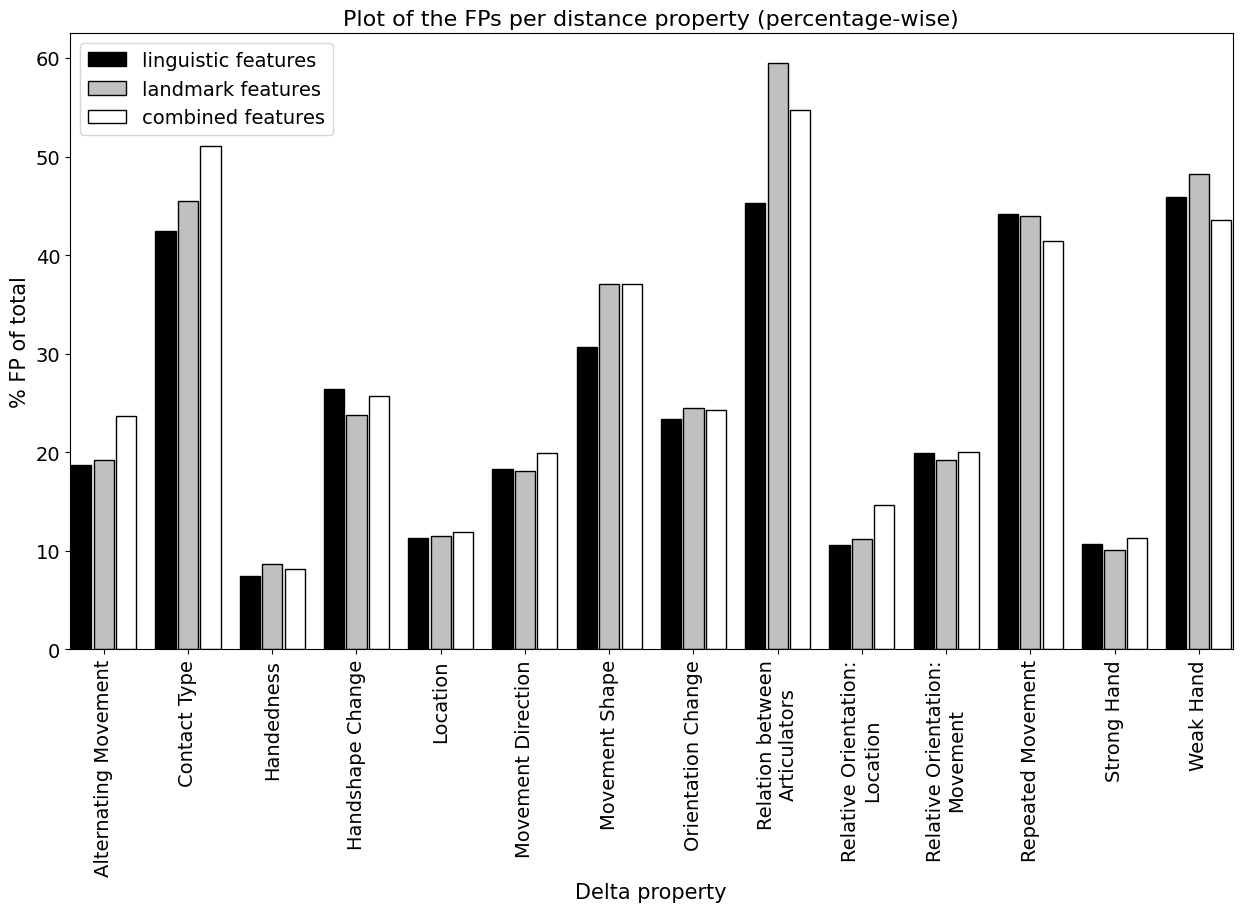

In [31]:
# Change the strings of the linguistic properties to have linebreaks
# So in the plots the text will wrap
def wrap_text_in_list(text_list):
    wrapped_text_list = []
    for text in text_list:
        num_spaces = text.count(' ')
        text_wrap = textwrap.wrap(text, 25 ) # if num_spaces > 1 else 16
        text_wrap = '\n'.join(text_wrap)
        wrapped_text_list.append(text_wrap)
    return wrapped_text_list

# Plot the bars of the percentage-wise FP counts in one plot for both models
# From: https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped
def bar_plot_multiple(ax, data, colors=None, total_width=0.8, single_width=1, legend=True, font_size = 12):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data to plot. Keys = the names of the data, items = a list of the values.

        Example: data = {"x":[1,2,3], "y":[1,2,3], "z":[1,2,3]}

    colors : array-like, optional, default: None
        A list of colors to use for the bars. If None, the colors are the standard matplotlib color cyle. 

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars will touch each other 
        within a group, values less than 1 will make these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """
    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []
    heights_left_bar = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x+x_offset, y, width=bar_width*single_width, color=colors[i % len(colors)], edgecolor = "black")
            height = bar[0].get_height()
            width = bar[0].get_width()
            loc = bar[0].get_x()
            
            if i % 3 == 0:
                heights_left_bar.append(height)
#                 if statistically_sign_ling[x]:
                    # Add an asterisk where the diff between two percentages is significant
#                     text_height = max(heights_left_bar[x], height)
#                     plt.text(loc+width/2, text_height, '*', ha='center', va='bottom', fontsize = 20) 

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
        
    # Draw legend if legend = True
    if legend:
        ax.legend(bars, data.keys(), fontsize = font_size, loc = 'upper left')
        
        
data = {'linguistic features': fp_diff_counts['_only_ling'], 
        'landmark features': fp_diff_counts['_only_lmrks'],
       'combined features': fp_diff_counts['_combined']}

# Resize figure, choose fontsize 
fig, ax = plt.subplots(figsize=(15, 8))
font_size = 14

# Plot the bars and significances
bar_plot_multiple(ax, data, total_width=.8, single_width=0.9, colors = ['black', 'silver', 'white'], font_size = font_size )

# Wrap label text so it fits better in the plot
linguistic_labels = list(set(fp_diff_properties['_only_ling']))
labels_wrapped = wrap_text_in_list(sorted(linguistic_labels))

# Add text to the plot
plt.title('Plot of the FPs per distance property (percentage-wise)', fontsize = font_size + 2)
plt.xticks(range(len(labels_wrapped)), labels_wrapped, rotation = 90, fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.ylabel('% FP of total', fontsize = font_size+1)
plt.xlabel('Delta property', fontsize = font_size+1)
plt.xlim(-0.4, 13.4)

# Store the plot as a .png
plt.savefig('./results/FPs_distance_property.png', bbox_inches = 'tight')
plt.show()